In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import gaussian_kde

In [2]:
df_train = pd.read_csv('data/evaluation/train.csv')

In [3]:
X = df_train.drop(columns=['strength'])
y = df_train['strength']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
class CVAE(nn.Module):
    def __init__(self, x_dim, cond_dim=1, latent_dim=3):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(x_dim + cond_dim, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + cond_dim, 32),
            nn.ReLU(),
            nn.Linear(32, x_dim)
        )

    def encode(self, x, c):
        xc = torch.cat([x, c], dim=1)
        h = self.encoder(xc)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, c):
        zc = torch.cat([z, c], dim=1)
        return self.decoder(zc)

    def forward(self, x, c):
        mu, logvar = self.encode(x, c)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z, c)
        return x_recon, mu, logvar

In [5]:
def loss_function(x_recon, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(x_recon, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [6]:
x_dim = X.shape[1]
model = CVAE(x_dim=x_dim, cond_dim=1, latent_dim=3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 250
last_values = [0] + [1] * 5
threshold = 0.002

for epoch in range(epochs):
    total_loss = 0
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        x_recon, mu, logvar = model(x_batch, y_batch.unsqueeze(1))
        loss = loss_function(x_recon, x_batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        last_values[epoch%len(last_values)] = total_loss
    
    absolute_errors = [abs(x - max(last_values)) for x in last_values]
    mae = sum(absolute_errors) / len(absolute_errors)
    if mae < threshold:
        print(f"Early stopping at epoch {epoch} with MAE: {mae:.4f}")
        break

    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 462.6048
Epoch 1, Loss: 198.9450
Epoch 2, Loss: 85.2263
Epoch 3, Loss: 37.9423
Epoch 4, Loss: 14.9101
Epoch 5, Loss: 5.5733
Epoch 6, Loss: 2.5318
Epoch 7, Loss: 1.6238
Epoch 8, Loss: 1.3471
Epoch 9, Loss: 1.2887
Epoch 10, Loss: 1.2914
Epoch 11, Loss: 1.2295
Epoch 12, Loss: 1.2065
Epoch 13, Loss: 1.2110
Epoch 14, Loss: 1.1655
Epoch 15, Loss: 1.1705
Epoch 16, Loss: 1.1368
Epoch 17, Loss: 1.1099
Epoch 18, Loss: 1.1118
Epoch 19, Loss: 1.0352
Epoch 20, Loss: 1.0561
Epoch 21, Loss: 1.0433
Epoch 22, Loss: 1.0177
Epoch 23, Loss: 1.0054
Epoch 24, Loss: 0.9936
Epoch 25, Loss: 0.9494
Epoch 26, Loss: 0.9559
Epoch 27, Loss: 0.9530
Epoch 28, Loss: 0.9331
Epoch 29, Loss: 0.9081
Epoch 30, Loss: 0.9408
Epoch 31, Loss: 0.9253
Epoch 32, Loss: 0.9241
Epoch 33, Loss: 0.8627
Epoch 34, Loss: 0.8515
Epoch 35, Loss: 0.8667
Epoch 36, Loss: 0.8669
Epoch 37, Loss: 0.8673
Epoch 38, Loss: 0.8586
Epoch 39, Loss: 0.8568
Epoch 40, Loss: 0.8160
Epoch 41, Loss: 0.8178
Epoch 42, Loss: 0.7944
Epoch 43, Loss

In [7]:
desired_strength = torch.tensor([[19.77]], dtype=torch.float32)

z = torch.randn(1, 3)

model.eval()
with torch.no_grad():
    generated = model.decode(z, desired_strength)
    generated_original = scaler.inverse_transform(generated.numpy())

print(generated_original)

[[205.70953   67.62035   64.61398  186.4746     4.064519 986.8272
  794.88715   33.422478]]


In [8]:
df_train[df_train['strength'] == 19.77]

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,252.5,0.0,0.0,185.7,0.0,1111.6,784.3,28,19.77


In [9]:
df_train.ash.unique()

array([  0. ,  86. , 116. , 118.3, 167. , 122. ,  71.5, 175. , 121.6,
        24.5, 136.6, 187. , 112. ,  94. , 185.3,  94.6, 125.2, 172.4,
        94.1, 132.1, 118.6, 106.9,  95.7, 150.4,  99.9, 174.7, 121.9,
       123.8,  87.5,  77. , 125.1, 143. , 174.2, 127.9, 100.4,  96.2,
        98. , 200.1,  95.6,  78.3,  96.7, 142. , 137.9, 113. , 100.5,
       125.4, 121.4, 124.1, 183.9,  78. , 132. ,  97.4, 138.7, 138. ,
       124.3, 185. , 141. , 195. , 132.6, 126. ,  93.9, 163.3, 173.5,
       107. , 161. ,  60. , 163.8,  82. ,  98.8, 200. , 142.7, 118.2,
        79. , 113.2, 106.2,  86.1, 128. , 158. ,  89.3, 123. , 130. ,
       159.9, 142.8, 124.8, 111. ,  78.4,  92. , 111.9, 120. , 128.6,
       109. , 100. , 143.6,  91. ,  89. ,  90. ])

## Generate multiple datapoints

In [10]:
strength = df_train['strength']

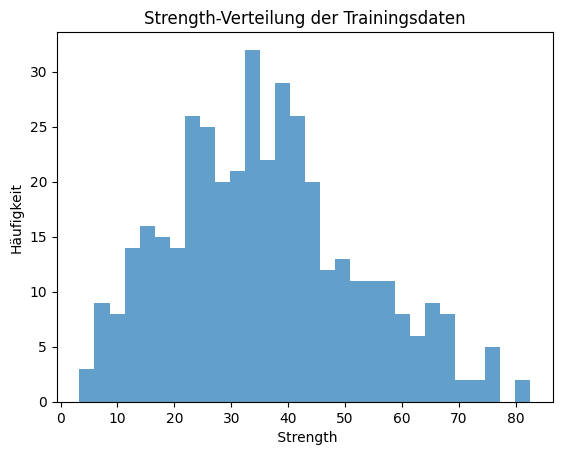

In [11]:
plt.hist(strength, bins=30, alpha=0.7)
plt.title('Strength-Verteilung der Trainingsdaten')
plt.xlabel(' Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [12]:
concrete = pd.read_csv('data/concrete.csv')
strength_whole = concrete['strength']

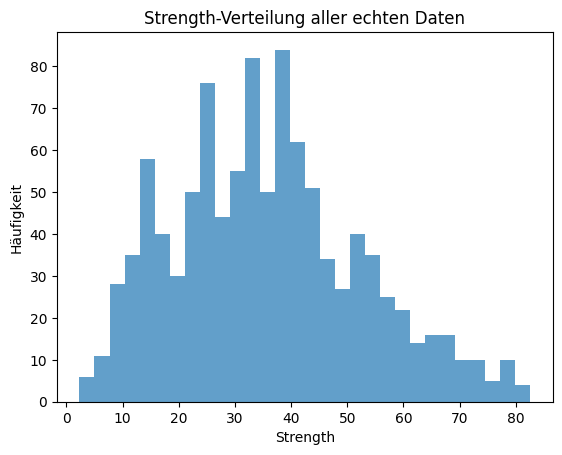

In [13]:
plt.hist(strength_whole, bins=30, alpha=0.7)
plt.title('Strength-Verteilung aller echten Daten')
plt.xlabel('Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [14]:
kde = gaussian_kde(strength)
zufallswerte = kde.resample(400)
zufallswerte[zufallswerte < 3] = 3
zufallswerte = zufallswerte.ravel()

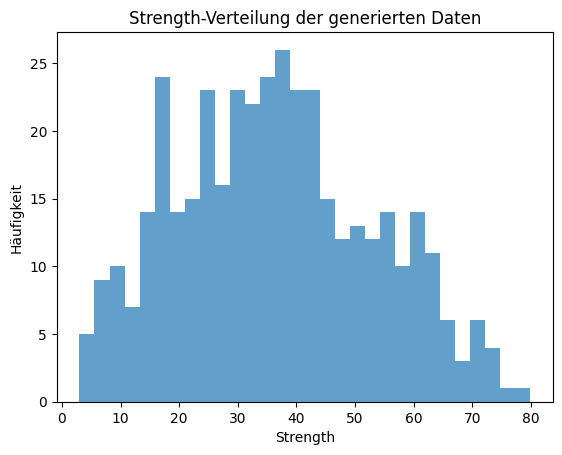

In [15]:
plt.hist(zufallswerte.ravel(), bins=30, alpha=0.7)
plt.title('Strength-Verteilung der generierten Daten')
plt.xlabel('Strength')
plt.ylabel('Häufigkeit')
plt.show()

In [ ]:
augemented_data = []

for i in range(zufallswerte.shape[0]):
    desired_strength = torch.tensor([[zufallswerte[i]]], dtype=torch.float32)
    z = torch.randn(1, 3)

    model.eval()
    with torch.no_grad():
        generated = model.decode(z, desired_strength)
        generated_original = scaler.inverse_transform(generated.numpy())

        generated_original = np.append(generated_original[0], zufallswerte[i])

    augemented_data.append(generated_original)

augemented_data

[array([264.34979248,  69.05298615,  56.36662292, 178.45414734,
          6.54069901, 979.80444336, 775.31799316,  55.4922142 ,
         39.07851181]),
 array([227.97866821,  70.2990799 ,  55.15353775, 186.92092896,
          5.59203863, 974.23419189, 794.15234375,  44.15431976,
         25.04173219]),
 array([242.60655212,  78.77973938,  54.41303253, 184.63374329,
          6.12197971, 967.96850586, 792.68432617,  48.48390198,
         30.12335143]),
 array([236.22322083,  65.43146515,  62.97047043, 180.70535278,
          5.08129406, 989.63439941, 780.52087402,  43.722435  ,
         30.67467994]),
 array([220.93696594,  73.13694763,  59.60033798, 186.19792175,
          4.99476004, 977.12646484, 795.24041748,  39.96706009,
         23.77872272]),
 array([275.06948853,  72.89464569,  56.05678558, 176.3886261 ,
          6.8124404 , 980.9095459 , 771.57055664,  57.00859833,
         42.71097431]),
 array([200.04592896,  63.04829788,  63.1838913 , 188.04222107,
          3.90964532, 99

In [17]:
augemented_data_df = pd.DataFrame(augemented_data, columns=df_train.columns)
augemented_data_train_data_df = pd.concat([df_train, augemented_data_df], ignore_index=True)

In [20]:
augemented_data_train_data_df.to_csv('data/evaluation/cvae_train.csv', index=False) 